In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import re
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
plt.rcParams['figure.dpi']= 100

import spacy
from spacy.lang.en.stop_words import STOP_WORDS

from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import ExtraTreesClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn.feature_selection import chi2
from sklearn.metrics import cohen_kappa_score



# plt.style.use('seaborn-colorblind')

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_colwidth', 100)

In [2]:
training_set = pd.read_csv('data/training_set_rel3.tsv', sep='\t', encoding = "ISO-8859-1")\
            .rename(columns={'essay_set': 'topic', 'domain1_score': 'target_score', 'domain2_score': 'topic2_target'})
training_set.sample()

,essay_id,topic,essay,rater1_domain1,rater2_domain1,rater3_domain1,target_score,rater1_domain2,rater2_domain2,topic2_target,rater1_trait1,rater1_trait2,rater1_trait3,rater1_trait4,rater1_trait5,rater1_trait6,rater2_trait1,rater2_trait2,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
10405,16355,6,The workers faced many obstacles in the process of building the mooring mast. The first reason w...,2,3,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
pip install git+https://github.com/MCFreddie777/language-check.git

  Cloning https://github.com/MCFreddie777/language-check.git to c:\users\hm7al\appdata\local\temp\pip-req-build-hthibo9b
  Resolved https://github.com/MCFreddie777/language-check.git to commit 337493f25b5a49af0a09b0e264f306eccefaff8f
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for language-check: filename=language_check-1.1-py3-none-any.whl size=90191350 sha256=f0e04424c93c9cd6bf8b3c92ec139038e46c4f4a0f341588d66ca7a46a27b31f
  Stored in directory: C:\Users\hm7al\AppData\Local\Temp\pip-ephem-wheel-cache-ib98ra1e\wheels\b9\02\98\003d75019bf143c7f1c32532654123c2b8d403b012b4685497
Successfully built language-check
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/MCFreddie777/language-check.git 'C:\Users\hm7al\AppData\Local\Temp\pip-req-build-hthibo9b'

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import language_check
import language_tool_python

In [4]:
# tool = language_check.LanguageTool('en-US')

tool = language_tool_python.LanguageTool('en-US')

text = u'A sentence with a error in the Hitchhiker’s Guide tot he Galaxy'
matches = tool.check(text)
x = tool.correct(text)
print(x)

A sentence with an error in the Hitchhiker’s Guide to the Galaxy


In [5]:
t0 = datetime.now()

training_set['matches'] = training_set['essay'].apply(lambda txt: tool.check(txt))
training_set['corrections'] = training_set.apply(lambda l: len(l['matches']), axis=1)
training_set['corrected'] = training_set.apply(lambda l: tool.correct(l['essay']), axis=1)

t1 = datetime.now()
print('Processing time: {}'.format(t1 - t0))


training_set.to_pickle('training_corr.pkl')

Processing time: 0:43:35.320490


In [6]:
training_set = pd.read_pickle('training_corr.pkl')

In [8]:
from string import punctuation

In [12]:
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 262.6 kB/s eta 0:00:49
     --------------------------------------- 0.0/12.8 MB 262.6 kB/s eta 0:00:49
     --------------------------------------- 0.0/12.8 MB 178.6 kB/s eta 0:01:12
     --------------------------------------- 0.0/12.8 MB 178.6 kB/s eta 0:01:12
     --------------------------------------- 0.0/12.8 MB 178.6 kB/s eta 0:01:12
     --------------------------------------- 0.0/12.8 MB 178.6 kB/s eta 0:01:12
     --------------------------------------- 0.0/12.8 MB 178.6 kB/s eta 0:01:12
     ---


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
sents = []
tokens = []
lemma = []
pos = []
ner = []

stop_words = set(STOP_WORDS)
stop_words.update(punctuation) # remove it if you need punctuation 

nlp = spacy.load('en_core_web_sm')

t0 = datetime.now()

# suppress numpy warnings
# AttributeError: module 'numpy' has no attribute 'warnings'
# np.warnings.filterwarnings('ignore')

# n_process instead of n_threads

for essay in nlp.pipe(training_set['corrected'], batch_size=100, n_process=3):
    if essay.is_parsed:
        tokens.append([e.text for e in essay])
        sents.append([sent.text.strip() for sent in essay.sents])
        pos.append([e.pos_ for e in essay])
        ner.append([e.text for e in essay.ents])
        lemma.append([n.lemma_ for n in essay])
    else:
        # We want to make sure that the lists of parsed results have the
        # same number of entries of the original Dataframe, so add some blanks in case the parse fails
        tokens.append(None)
        lemma.append(None)
        pos.append(None)
        sents.append(None)
        ner.append(None)

training_set['tokens'] = tokens
training_set['lemma'] = lemma
training_set['pos'] = pos
training_set['sents'] = sents
training_set['ner'] = ner

t1 = datetime.now()
print('Processing time: {}'.format(t1 - t0))    

C:\Users\hm7al\AppData\Local\Temp\ipykernel_6604\3086039458.py:21: DeprecationWarning: [W107] The property `Doc.is_parsed` is deprecated. Use `Doc.has_annotation("DEP")` instead.
  if essay.is_parsed:


Processing time: 0:01:47.709893


In [17]:
training_set.to_pickle('training_spacy.pkl')


In [18]:
training_set.sample(7)

,essay_id,topic,essay,rater1_domain1,rater2_domain1,rater3_domain1,target_score,rater1_domain2,rater2_domain2,topic2_target,rater1_trait1,rater1_trait2,rater1_trait3,rater1_trait4,rater1_trait5,rater1_trait6,rater2_trait1,rater2_trait2,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6,matches,corrections,corrected,tokens,lemma,pos,sents,ner
2827,4022,2,"Everywhere I go, there always seems to be something, small or big, that can be considered offens...",4,4,NaN,4,4.0,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Offset 205, length 15, Rule ID: MORFOLOGIK_RULE_EN_US\nMessage: Possible spelling mistake found...",10,"Everywhere I go, there always seems to be something, small or big, that can be considered offens...","[Everywhere, I, go, ,, there, always, seems, to, be, something, ,, small, or, big, ,, that, can,...","[everywhere, I, go, ,, there, always, seem, to, be, something, ,, small, or, big, ,, that, can, ...","[ADV, PRON, VERB, PUNCT, PRON, ADV, VERB, PART, AUX, PRON, PUNCT, ADJ, CCONJ, ADJ, PUNCT, PRON, ...","[Everywhere I go, there always seems to be something, small or big, that can be considered offen...",[]
2556,3751,2,Let your mind wander to a place of peace and tranquility. You are in a world of endless possibli...,4,5,NaN,4,4.0,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Offset 88, length 12, Rule ID: MORFOLOGIK_RULE_EN_US\nMessage: Possible spelling mistake found....",10,Let your mind wander to a place of peace and tranquility. You are in a world of endless possibil...,"[Let, your, mind, wander, to, a, place, of, peace, and, tranquility, ., You, are, in, a, world, ...","[let, your, mind, wander, to, a, place, of, peace, and, tranquility, ., you, be, in, a, world, o...","[VERB, PRON, NOUN, VERB, ADP, DET, NOUN, ADP, NOUN, CCONJ, NOUN, PUNCT, PRON, AUX, ADP, DET, NOU...","[Let your mind wander to a place of peace and tranquility., You are in a world of endless possib...","[one, one]"
11541,18789,7,"One day my brother, my mom and me were going to the doctors because my brother was sick. When w...",10,9,NaN,19,NaN,NaN,NaN,3.0,2.0,2.0,3.0,NaN,NaN,2.0,2.0,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Offset 31, length 2, Rule ID: CONFUSION_OF_ME_I\nMessage: Did you mean “I”?\nSuggestion: I\nOne...",13,"One day my brother, my mom and I were going to the doctors because my brother was sick. When we ...","[One, day, my, brother, ,, my, mom, and, I, were, going, to, the, doctors, because, my, brother,...","[one, day, my, brother, ,, my, mom, and, I, be, go, to, the, doctor, because, my, brother, be, s...","[NUM, NOUN, PRON, NOUN, PUNCT, PRON, NOUN, CCONJ, PRON, AUX, VERB, ADP, DET, NOUN, SCONJ, PRON, ...","[One day my brother, my mom and I were going to the doctors because my brother was sick., When w...","[One day, two minutes, two hours]"
11348,18582,7,"One day I went to the hospitle the nurses gave me a ivy, akatt scan and pulled tare of my arm. I...",8,11,NaN,19,NaN,NaN,NaN,2.0,2.0,2.0,2.0,NaN,NaN,2.0,3.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Offset 22, length 8, Rule ID: MORFOLOGIK_RULE_EN_US\nMessage: Possible spelling mistake found.\...",17,"One day I went to the hospital the nurses gave me an ivy, apart scan and pulled tare of my arm. ...","[One, day, I, went, to, the, hospital, the, nurses, gave, me, an, ivy, ,, apart, scan, and, pull...","[one, day, I, go, to, the, hospital, the, nurse, give, I, an, ivy, ,, apart, scan, and, pull, ta...","[NUM, NOUN, PRON, VERB, ADP, DET, NOUN, DET, NOUN, VERB, PRON, DET, NOUN, PUNCT, ADV, PROPN, CCO...","[One day I went to the hospital the nurses gave me an ivy, apart scan and pulled tare of my arm....","[One day, First, @NUM1 o'clock pm, all day]"
9285,15235,6,The builders of the Empire State Building faced many obstacles in attempting to allow dirigibles...,3,1,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [19]:
"""Choose arbitrary essay from highest available target_score for each topic.
all other essays will be compared to these. 
The uncorrected essays will be used since the reference essays should have fewer errors.
"""
reference_essays = {1: 161, 2: 3022, 3: 5263, 4: 5341, 5: 7209, 6: 8896, 7: 11796, 8: 12340} # topic: essay_id

references = {}

t0 = datetime.now()

nlp = spacy.load('en_core_web_sm')
stop_words = set(STOP_WORDS)

# generate nlp object for reference essays:
for topic, index in reference_essays.items():
    references[topic] = nlp(training_set.iloc[index]['essay'])

# generate document similarity for each essay compared to topic reference
training_set['similarity'] = training_set.apply(lambda row: nlp(row['essay']).similarity(references[row['topic']]), axis=1)

t1 = datetime.now()
print('Processing time: {}'.format(t1 - t0))

C:\Users\hm7al\AppData\Local\Temp\ipykernel_6604\4158347446.py:19: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  training_set['similarity'] = training_set.apply(lambda row: nlp(row['essay']).similarity(references[row['topic']]), axis=1)


Processing time: 0:05:34.318975


In [20]:
t0 = datetime.now()

training_set['token_count'] = training_set.apply(lambda x: len(x['tokens']), axis=1)
training_set['unique_token_count'] = training_set.apply(lambda x: len(set(x['tokens'])), axis=1)
training_set['nostop_count'] = training_set \
            .apply(lambda x: len([token for token in x['tokens'] if token not in stop_words]), axis=1)
training_set['sent_count'] = training_set.apply(lambda x: len(x['sents']), axis=1)
training_set['ner_count'] = training_set.apply(lambda x: len(x['ner']), axis=1)
training_set['comma'] = training_set.apply(lambda x: x['corrected'].count(','), axis=1)
training_set['question'] = training_set.apply(lambda x: x['corrected'].count('?'), axis=1)
training_set['exclamation'] = training_set.apply(lambda x: x['corrected'].count('!'), axis=1)
training_set['quotation'] = training_set.apply(lambda x: x['corrected'].count('"') + x['corrected'].count("'"), axis=1)
training_set['organization'] = training_set.apply(lambda x: x['corrected'].count(r'@ORGANIZATION'), axis=1)
training_set['caps'] = training_set.apply(lambda x: x['corrected'].count(r'@CAPS'), axis=1)
training_set['person'] = training_set.apply(lambda x: x['corrected'].count(r'@PERSON'), axis=1)
training_set['location'] = training_set.apply(lambda x: x['corrected'].count(r'@LOCATION'), axis=1)
training_set['money'] = training_set.apply(lambda x: x['corrected'].count(r'@MONEY'), axis=1)
training_set['time'] = training_set.apply(lambda x: x['corrected'].count(r'@TIME'), axis=1)
training_set['date'] = training_set.apply(lambda x: x['corrected'].count(r'@DATE'), axis=1)
training_set['percent'] = training_set.apply(lambda x: x['corrected'].count(r'@PERCENT'), axis=1)
training_set['noun'] = training_set.apply(lambda x: x['pos'].count('NOUN'), axis=1)
training_set['adj'] = training_set.apply(lambda x: x['pos'].count('ADJ'), axis=1)
training_set['pron'] = training_set.apply(lambda x: x['pos'].count('PRON'), axis=1)
training_set['verb'] = training_set.apply(lambda x: x['pos'].count('VERB'), axis=1)
training_set['noun'] = training_set.apply(lambda x: x['pos'].count('NOUN'), axis=1)
training_set['cconj'] = training_set.apply(lambda x: x['pos'].count('CCONJ'), axis=1)
training_set['adv'] = training_set.apply(lambda x: x['pos'].count('ADV'), axis=1)
training_set['det'] = training_set.apply(lambda x: x['pos'].count('DET'), axis=1)
training_set['propn'] = training_set.apply(lambda x: x['pos'].count('PROPN'), axis=1)
training_set['num'] = training_set.apply(lambda x: x['pos'].count('NUM'), axis=1)
training_set['part'] = training_set.apply(lambda x: x['pos'].count('PART'), axis=1)
training_set['intj'] = training_set.apply(lambda x: x['pos'].count('INTJ'), axis=1)

t1 = datetime.now()
print('Processing time: {}'.format(t1 - t0))
training_set.to_pickle('training_features.pkl')

Processing time: 0:00:03.073166


In [21]:
training_set['matches'][0]

[Match({'ruleId': 'SPACE_BEFORE_PARENTHESIS', 'message': 'It appears that a white space is missing.', 'replacements': [' ('], 'offsetInContext': 43, 'context': '...w people, helps us learn about the globe(astronomy) and keeps us out of troble! T...', 'offset': 186, 'errorLength': 1, 'category': 'TYPOGRAPHY', 'ruleIssueType': 'typographical', 'sentence': 'Dear local newspaper, I think effects computers have on people are great learning skills/affects because they give us time to chat with friends/new people, helps us learn about the globe(astronomy) and keeps us out of troble!'}),
 Match({'ruleId': 'MORFOLOGIK_RULE_EN_US', 'message': 'Possible spelling mistake found.', 'replacements': ['trouble', 'treble'], 'offsetInContext': 43, 'context': '...he globe(astronomy) and keeps us out of troble! Thing about! Dont you think so? How wo...', 'offset': 218, 'errorLength': 6, 'category': 'TYPOS', 'ruleIssueType': 'misspelling', 'sentence': 'Dear local newspaper, I think effects computers have on

In [22]:
training_set['corrected'][0]

"Dear local newspaper, I think effects computers have on people are great learning skills/affects because they give us time to chat with friends/new people, helps us learn about the globe (astronomy) and keeps us out of trouble! Thing about! Don't you think so? How would you feel if your teenager is always on the phone with friends! Do you every time to chat with your friends or business partner about things? Well now - there's a new way to chat the computer, theirs plenty of sites on the internet to do so: @ORGANIZATION1, @ORGANIZATION2, @CAPS1, Facebook, MySpace etc. Just think now while your setting up meeting with your boss on the computer, your teenager is having fun on the phone not rushing to get off because you want to use it. How did you learn about other countries/states outside yours? Well I have by computer/internet, it's a new way to learn about what going on in our time! You might think your child spends a lot of time on the computer, but ask them so question about the ec

In [23]:
training_set['tokens'][0]

['Dear',
 'local',
 'newspaper',
 ',',
 'I',
 'think',
 'effects',
 'computers',
 'have',
 'on',
 'people',
 'are',
 'great',
 'learning',
 'skills',
 '/',
 'affects',
 'because',
 'they',
 'give',
 'us',
 'time',
 'to',
 'chat',
 'with',
 'friends',
 '/',
 'new',
 'people',
 ',',
 'helps',
 'us',
 'learn',
 'about',
 'the',
 'globe',
 '(',
 'astronomy',
 ')',
 'and',
 'keeps',
 'us',
 'out',
 'of',
 'trouble',
 '!',
 'Thing',
 'about',
 '!',
 'Do',
 "n't",
 'you',
 'think',
 'so',
 '?',
 'How',
 'would',
 'you',
 'feel',
 'if',
 'your',
 'teenager',
 'is',
 'always',
 'on',
 'the',
 'phone',
 'with',
 'friends',
 '!',
 'Do',
 'you',
 'every',
 'time',
 'to',
 'chat',
 'with',
 'your',
 'friends',
 'or',
 'business',
 'partner',
 'about',
 'things',
 '?',
 'Well',
 'now',
 '-',
 'there',
 "'s",
 'a',
 'new',
 'way',
 'to',
 'chat',
 'the',
 'computer',
 ',',
 'theirs',
 'plenty',
 'of',
 'sites',
 'on',
 'the',
 'internet',
 'to',
 'do',
 'so',
 ':',
 '@ORGANIZATION1',
 ',',
 '@ORGANIZ

In [14]:
training_set['lemma'][0]

['dear',
 'local',
 'newspaper',
 ',',
 '-PRON-',
 'think',
 'effect',
 'computer',
 'have',
 'on',
 'people',
 'be',
 'great',
 'learning',
 'skill',
 '/',
 'affect',
 'because',
 '-PRON-',
 'give',
 '-PRON-',
 'time',
 'to',
 'chat',
 'with',
 'friend',
 '/',
 'new',
 'people',
 ',',
 'help',
 '-PRON-',
 'learn',
 'about',
 'the',
 'globe(astronomy',
 ')',
 'and',
 'keep',
 '-PRON-',
 'out',
 'of',
 'trouble',
 '!',
 'thing',
 'about',
 '!',
 'do',
 'not',
 '-PRON-',
 'think',
 'so',
 '?',
 'how',
 'would',
 '-PRON-',
 'feel',
 'if',
 '-PRON-',
 'teenager',
 'be',
 'always',
 'on',
 'the',
 'phone',
 'with',
 'friend',
 '!',
 'do',
 '-PRON-',
 'ever',
 'time',
 'to',
 'chat',
 'with',
 '-PRON-',
 'friend',
 'or',
 'business',
 'partner',
 'about',
 'thing',
 '.',
 'well',
 'now',
 '-',
 'there',
 'be',
 'a',
 'new',
 'way',
 'to',
 'chat',
 'the',
 'computer',
 ',',
 '-PRON-',
 'plenty',
 'of',
 'site',
 'on',
 'the',
 'internet',
 'to',
 'do',
 'so',
 ':',
 '@ORGANIZATION1',
 ',',
 

In [24]:
training_set['ner'][0]

['Facebook, MySpace']

In [25]:
training_set = pd.read_pickle('training_features.pkl')

In [26]:
training_set.columns

Index(['essay_id', 'topic', 'essay', 'rater1_domain1', 'rater2_domain1', 'rater3_domain1', 'target_score', 'rater1_domain2', 'rater2_domain2', 'topic2_target', 'rater1_trait1', 'rater1_trait2', 'rater1_trait3', 'rater1_trait4', 'rater1_trait5', 'rater1_trait6', 'rater2_trait1', 'rater2_trait2', 'rater2_trait3', 'rater2_trait4', 'rater2_trait5', 'rater2_trait6', 'rater3_trait1', 'rater3_trait2', 'rater3_trait3', 'rater3_trait4', 'rater3_trait5', 'rater3_trait6', 'matches', 'corrections',
       'corrected', 'tokens', 'lemma', 'pos', 'sents', 'ner', 'similarity', 'token_count', 'unique_token_count', 'nostop_count', 'sent_count', 'ner_count', 'comma', 'question', 'exclamation', 'quotation', 'organization', 'caps', 'person', 'location', 'money', 'time', 'date', 'percent', 'noun', 'adj', 'pron', 'verb', 'cconj', 'adv', 'det', 'propn', 'num', 'part', 'intj'],
      dtype='object')

In [27]:
training_set=training_set.drop(columns=['rater1_domain1','rater2_domain1','essay_id','rater3_domain1','rater1_domain2','rater2_domain2','rater1_trait1','rater1_trait2','rater1_trait3','rater1_trait4','rater1_trait5','rater1_trait6','rater2_trait1','rater2_trait2','rater2_trait3','rater2_trait4','rater2_trait5','rater2_trait6','rater3_trait1','rater3_trait2','rater3_trait3','rater3_trait4','rater3_trait5','rater3_trait6'])
training_set.sample(7)

,topic,essay,target_score,topic2_target,matches,corrections,corrected,tokens,lemma,pos,sents,ner,similarity,token_count,unique_token_count,nostop_count,sent_count,ner_count,comma,question,exclamation,quotation,organization,caps,person,location,money,time,date,percent,noun,adj,pron,verb,cconj,adv,det,propn,num,part,intj
12480,8,"From Laughter to @CAPS1 @CAPS2 the first day of school last year, I ...",40,NaN,"[Offset 0, length 28, Rule ID: WHITESPACE_RULE\nMessage: Possible typo: you repeated a whitespac...",16,"From Laughter to @CAPS1 @CAPS2 the first day of school last year, I walked through the doors of...","[ , From, Laughter, to, @CAPS1, @CAPS2, the, first, day, of, school, last, year, ,, I, walked, t...","[ , from, Laughter, to, @CAPS1, @CAPS2, the, first, day, of, school, last, year, ,, I, walk, thr...","[SPACE, ADP, PROPN, ADP, PROPN, PROPN, DET, ADJ, NOUN, ADP, NOUN, ADJ, NOUN, PUNCT, PRON, VERB, ...","[From Laughter to @CAPS1 @CAPS2 the first day of school last year, I walked through the doors of...","[Laughter, the first day, last year, two, first, the day, the first day, second, a minute, A yea...",0.867403,561,220,306,38,12,25,2,0,13,0,11,1,0,0,0,0,0,68,34,99,86,24,22,40,9,2,18,0
3792,3,"The features of the setting do affect the cyclist. one example is, the condition of his jar",0,NaN,"[Offset 51, length 3, Rule ID: UPPERCASE_SENTENCE_START\nMessage: This sentence does not start w...",1,"The features of the setting do affect the cyclist. One example is, the condition of his jar","[The, features, of, the, setting, do, affect, the, cyclist, ., One, example, is, ,, the, conditi...","[the, feature, of, the, setting, do, affect, the, cyclist, ., one, example, be, ,, the, conditio...","[DET, NOUN, ADP, DET, NOUN, AUX, VERB, DET, NOUN, PUNCT, NUM, NOUN, AUX, PUNCT, DET, NOUN, ADP, ...","[The features of the setting do affect the cyclist., One example is, the condition of his jar]",[One],0.649033,19,16,11,2,1,1,0,0,0,0,0,0,0,0,0,0,0,6,0,1,1,0,0,4,0,1,0,0
12238,7,In the @DATE1 time my mom had planned of trip for us to go to @LOCATION1 for two weeks. We were ...,16,NaN,"[Offset 134, length 6, Rule ID: UPPERCASE_SENTENCE_START\nMessage: This sentence does not start ...",3,In the @DATE1 time my mom had planned of trip for us to go to @LOCATION1 for two weeks. We were ...,"[In, the, @DATE1, time, my, mom, had, planned, of, trip, for, us, to, go, to, @LOCATION1, for, t...","[in, the, @date1, time, my, mom, have, plan, of, trip, for, we, to, go, to, @LOCATION1, for, two...","[ADP, DET, NOUN, NOUN, PRON, NOUN, AUX, VERB, ADP, NOUN, SCONJ, PRON, PART, VERB, ADP, PROPN, AD...","[In the @DATE1 time my mom had planned of trip for us to go to @LOCATION1 for two weeks., We wer...",[two weeks],0.814250,109,65,46,7,1,1,2,0,0,0,0,0,2,0,0,1,0,15,2,20,19,6,7,3,2,1,6,0
243,1,Dear @CITY1 current I am writing to you on the issue about people spending to much time on compu...,7,NaN,"[Offset 75, length 2, Rule ID: TO_TOO\nMessage: Did you mean “too”?\nSuggestion: too\n... you on...",31,Dear @CITY1 current I am writing to you on the issue about people spending too much time on comp...,"[Dear, @CITY1, current, I, am, writing, to, you, on, the, issue, about, people, spending, too, m...","[Dear, @CITY1, current, I, be, write, to, you, on, the, issue, about, people, spend, too, much, ...","[PROPN, PROPN, NOUN, PRON, AUX, VERB, ADP, PRON, ADP, DET, NOUN, ADP, NOUN, VERB, ADV, ADJ, NOUN...",[Dear @CITY1 current I am writing to you on the issue about people spending too much time on com...,"[next day, Foe, MySpace]",0.894209,372,160,171,15,3,8,0,0,4,0,0,0,0,0,0,0,0,68,27,51,54,12,16,23,4,0,16,0
5501,4,Saeng said that when the tree she bought starts budding she will take the test over. She means t...,1,NaN,"[Offset 0, length 5, Rule ID: MORFOLOGIK_RULE_EN_US\nMessage: Possible spelling mistake found.\n...",6,Sang said that when the tree she bought starts budding she will take the test over. She means th...,"[Sang, said, that, when, the, tree, she, bought, 

## Feature Selection


In [28]:
predictors = [  'corrections',
                'similarity',
                'unique_token_count',
                'sent_count',
                'ner_count',
                'comma',
                'question',
                'exclamation',
                'quotation',
                'organization',
                'caps',
                'person',
                'location',
                'money',
                'time',
                'date',
                'percent',
                'noun',
                'adj',
                'pron',
                'verb',
                'cconj',
                'adv',
                'det',
                'propn',
                'num',
                'part',
                'intj'
                ]

In [29]:
X=training_set[predictors]
y=training_set['target_score']
best_features= SelectKBest(score_func=chi2,k=10)
fit=best_features.fit(X,y)

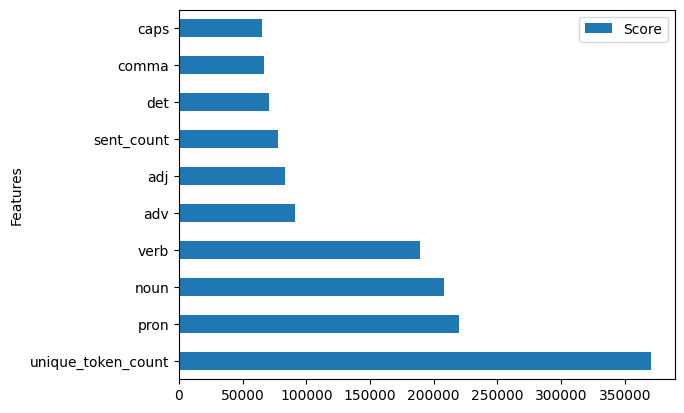

In [30]:
df_score=pd.DataFrame(fit.scores_)
dfcolumns=pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns,df_score],axis=1)
featureScores.columns=['Features','Score']
featureScores=featureScores.set_index('Features')
featureScores.nlargest(10,'Score').plot(kind='barh')
plt.show()

When the All the essays are taken in whole the best features are stated above let us take now the features for all the topics

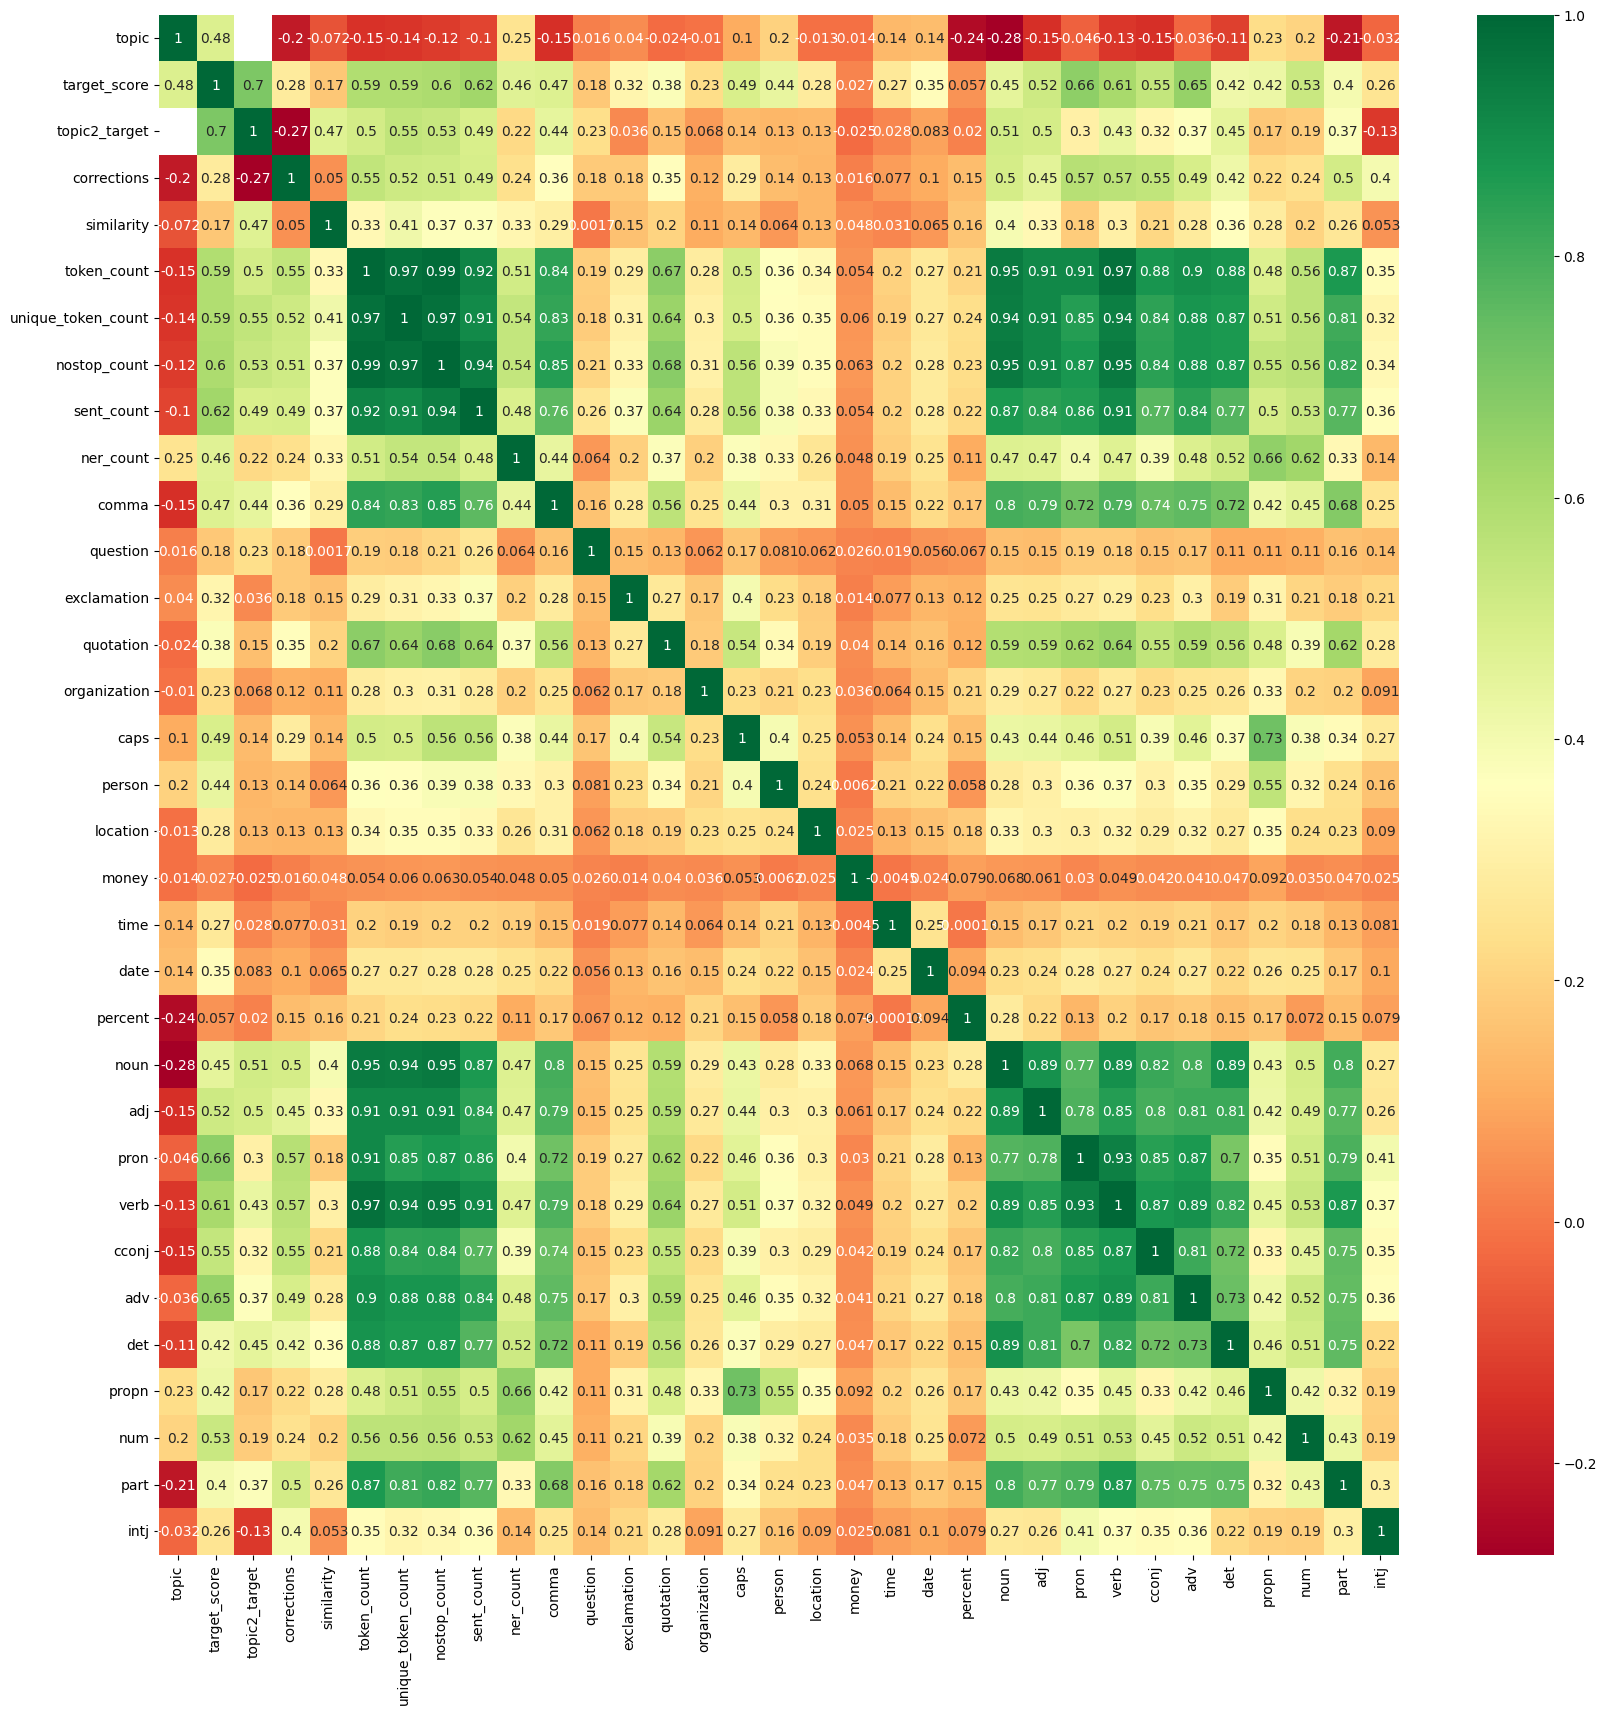

In [32]:
import seaborn as sns
#get correlations of each features in dataset
corrmat = training_set.corr(numeric_only=True)
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(training_set[top_corr_features].corr(),annot=True,cmap="RdYlGn")

The target_score is Least Coorelated with the percent,money,features so we can deduct them from the list of the predictor columns

In [33]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)

ExtraTreesClassifier()

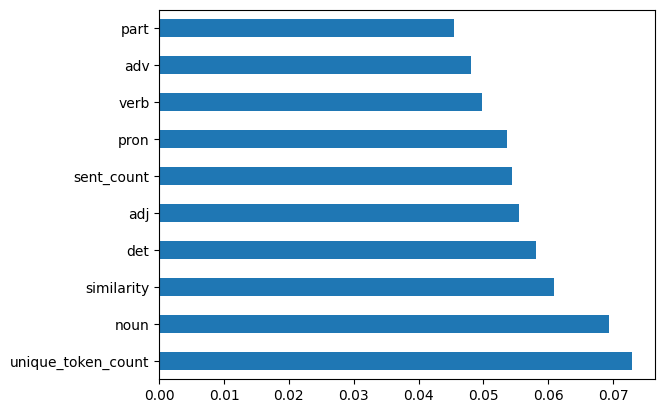

In [34]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [35]:
training_set.shape

(12976, 41)

In [36]:
selector = SelectKBest(f_regression, k=10) 


df = pd.DataFrame()

for topic in range(1, 9):
    kpredictors = []
    
    
    for p in predictors:
        if np.std(training_set[training_set.topic == topic][p], axis=0) != 0:
            kpredictors.append(p)
            
    
    X = training_set[training_set.topic == topic][kpredictors]
    y = training_set[training_set.topic == topic].target_score
    
    selector.fit(X, y)

    
    mask = selector.get_support(indices=True)

    selected_features = training_set[training_set.topic == topic][predictors].columns[mask]
    df["Topic " + str(topic)] = selected_features
df

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8
0,similarity,unique_token_count,similarity,unique_token_count,similarity,similarity,similarity,similarity
1,unique_token_count,sent_count,unique_token_count,sent_count,unique_token_count,unique_token_count,unique_token_count,unique_token_count
2,sent_count,comma,sent_count,ner_count,sent_count,sent_count,sent_count,sent_count
3,comma,noun,comma,comma,date,comma,comma,ner_count
4,noun,adj,date,percent,percent,date,noun,comma
5,adj,pron,percent,noun,noun,percent,adj,noun
6,verb,verb,noun,adj,adj,adj,pron,adj
7,cconj,adv,adj,pron,pron,verb,verb,verb
8,adv,det,verb,verb,verb,cconj,adv,adv
9,det,part,cconj,adv,cconj,propn,det,det


In [37]:
def evaluate(df, topic, features, model):
    """Regression pipeline with kappa evaluation"""

    X = df[df['topic'] == topic][features]
    y = df[df['topic'] == topic]['target_score'].astype(np.float64)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=26)
    
    pipeline = Pipeline(model)
    pipeline.fit(X_train, y_train)

    
    y_pred = pipeline.predict(X_test)

    return quadratic_weighted_kappa(y_pred, y_test)

In [38]:
def confusion_matrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat


def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings

def quadratic_weighted_kappa(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Calculates the quadratic weighted kappa
    quadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = confusion_matrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return 1.0 - numerator / denominator
def mean_quadratic_weighted_kappa(kappas, weights=None):
    """
    Calculates the mean of the quadratic
    weighted kappas after applying Fisher's r-to-z transform, which is
    approximately a variance-stabilizing transformation.  This
    transformation is undefined if one of the kappas is 1.0, so all kappa
    values are capped in the range (-0.999, 0.999).  The reverse
    transformation is then applied before returning the result.
    mean_quadratic_weighted_kappa(kappas), where kappas is a vector of
    kappa values
    mean_quadratic_weighted_kappa(kappas, weights), where weights is a vector
    of weights that is the same size as kappas.  Weights are applied in the
    z-space
    """
    kappas = np.array(kappas, dtype=float)
    if weights is None:
        weights = np.ones(np.shape(kappas))
    else:
        weights = weights / np.mean(weights)

    # ensure that kappas are in the range [-.999, .999]
    kappas = np.array([min(x, .999) for x in kappas])
    kappas = np.array([max(x, -.999) for x in kappas])

    z = 0.5 * np.log((1 + kappas) / (1 - kappas)) * weights
    z = np.mean(z)
    return (np.exp(2 * z) - 1) / (np.exp(2 * z) + 1)

In [39]:
predictors = [  
                
                'corrections',
                'similarity',
                'token_count',
                'unique_token_count',
                'nostop_count',
                'sent_count',
                'ner_count',
                'comma',
                'question',
                'exclamation',
                'quotation',
                'organization',
                'caps',
                'person',
                'location',
                'money',
                'time',
                'date',
                'percent',
                'noun',
                'adj',
                'pron',
                'verb',
                'cconj',
                'adv',
                'det',
                'propn',
                'num',
                'part',
                'intj'
                ]
models = [
            [('scaler', StandardScaler()),('linearSVC', LinearSVC(C=0.01))] ,
            [('scaler', StandardScaler()),('lm', LinearRegression())], 
            [('rf', RandomForestRegressor(random_state=26))],  
            [('en', ElasticNet(l1_ratio=0.01, alpha=0.1, max_iter=100000, random_state=26))] 
        ]

for steps in models:
    kappas = []
    weights = []
    for topic in range(1,9):
        kappas.append(evaluate(training_set, topic, predictors, steps))
        weights.append(len(training_set[training_set.topic==topic]))

    mqwk = mean_quadratic_weighted_kappa(kappas, weights)
    print(steps)
    print('Weighted by topic Kappa score: {:.4f}'.format(mqwk))
    print('')

c:\Users\hm7al\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\hm7al\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\hm7al\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\hm7al\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dua

[('scaler', StandardScaler()), ('linearSVC', LinearSVC(C=0.01))]
Weighted by topic Kappa score: 0.5882

[('scaler', StandardScaler()), ('lm', LinearRegression())]
Weighted by topic Kappa score: 0.6363

[('rf', RandomForestRegressor(random_state=26))]
Weighted by topic Kappa score: 0.6304

[('en', ElasticNet(alpha=0.1, l1_ratio=0.01, max_iter=100000, random_state=26))]
Weighted by topic Kappa score: 0.6264



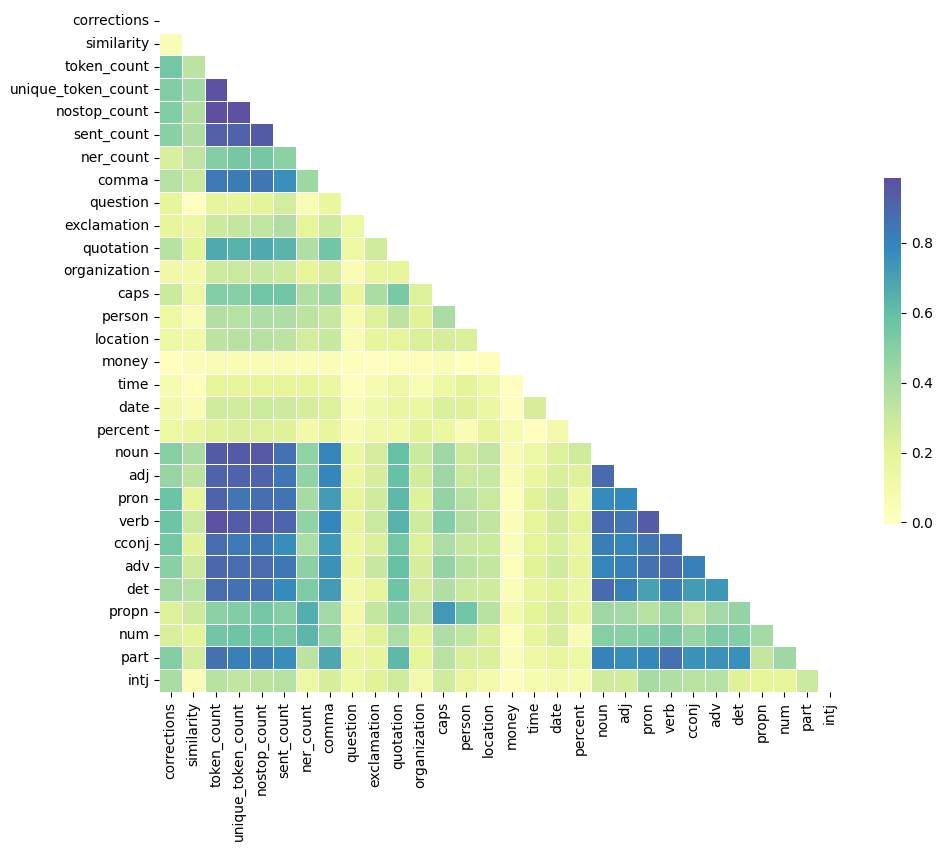

In [41]:
corr = training_set[predictors].corr() # default: Pearson
mask = np.zeros_like(corr, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
g = sns.heatmap(corr, mask=mask, cmap='Spectral', center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [43]:
training_set['l_essay'] = training_set['lemma'].apply(' '.join)

vectorizer = TfidfVectorizer(max_df=.2, 
                             min_df=3, 
                             max_features=2000,
                             stop_words=list(STOP_WORDS)) # default: binary=False
tfidf_matrix = vectorizer.fit_transform(training_set.l_essay) # using lemmatized essays
tfidf_matrix.shape

c:\Users\hm7al\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(12976, 2000)

In [44]:
combined_dense = pd.concat([pd.DataFrame(tfidf_matrix.todense()), 
                            training_set[predictors], 
                            training_set['topic'], 
                            training_set['target_score']], axis=1)
combined_dense.shape


(12976, 2032)

In [45]:
def tf_evaluate(df, topic):
    # Regression pipeline with kappa evaluation
    paramgrid = {'l1_ratio': [.01, .1, .5, .9], 'alpha': [0.01, .1, 1]}
    X = df[df['topic'] == topic].drop(['topic', 'target_score'], axis=1)
    y = df[df['topic'] == topic]['target_score'].astype(np.float64)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=26)
    
    gs = GridSearchCV(ElasticNet(max_iter=100000, random_state=26),param_grid=paramgrid,cv=5)
    gs.fit(X_train, y_train)
    print('Topic', topic, 'best parameters:', gs.best_params_)
    y_pred = gs.predict(X_test)
    
    return quadratic_weighted_kappa(y_pred, y_test)

In [47]:
kappas = []
weights = []

# Convert feature names to strings
combined_dense.columns = combined_dense.columns.astype(str)

for topic in range(1,9):
    kappas.append(tf_evaluate(combined_dense, topic))
    weights.append(len(training_set[training_set.topic==topic]))
    
mqwk = mean_quadratic_weighted_kappa(kappas, weights=weights)
print('Weighted by topic Kappa score: {:.4f}'.format(mqwk))

Topic 1 best parameters: {'alpha': 1, 'l1_ratio': 0.1}
Topic 2 best parameters: {'alpha': 0.01, 'l1_ratio': 0.01}
Topic 3 best parameters: {'alpha': 0.01, 'l1_ratio': 0.01}
Topic 4 best parameters: {'alpha': 0.01, 'l1_ratio': 0.01}
Topic 5 best parameters: {'alpha': 0.01, 'l1_ratio': 0.01}
Topic 6 best parameters: {'alpha': 0.01, 'l1_ratio': 0.01}
Topic 7 best parameters: {'alpha': 0.01, 'l1_ratio': 0.9}
Topic 8 best parameters: {'alpha': 1, 'l1_ratio': 0.5}
Weighted by topic Kappa score: 0.6489
